<font size = 8> **Creating a mask for MEASO regions** </font>

Our analysis uses the [Marine Ecosystem Assessment for the Southern Ocean (MEASO) regions](https://sokiaq.atlassian.net/wiki/spaces/MEASO/pages/4348444548/MEASO+Approach+Structure+Format) to evaluate and quantify the rate of change in the physical environment of the Southern Ocean. These regions were designed to establish a standard spatial scale for reporting and assessing environmental and ecosystem change in the SO, and to facilitate comparisons across studies and throughout time. The MEASO regions boundaries were obtained from the [`measoshape`](https://australianantarcticdivision.github.io/measoshapes/) package for `R`.  We used this shapefile (i.e., polygon) to create a 3D mask that we will use for all the analyses at a sector level that are described in this series of notebooks.

# Setting working directory
In order to ensure these notebooks work correctly, we will set the working directory. We assume that you have saved a copy of this repository in your home directory (represented by `~` in the code chunk below). If you have saved this repository elsewhere in your machine, you need to ensure you update this line with the correct filepath where you saved these notebooks.

In [1]:
import os
#Ensure you update this filepath if you have saved these notebooks elsewhere in your machine
os.chdir(os.path.expanduser('~/ACCESS-OM2-01_EcologicallyRelevantVariables/Scripts'))

You can print your working directory using the chunk below to make sure you are in the correct folder containing these notebooks.

In [ ]:
!pwd

# Loading relevant libraries
Note that the `ZonalStatsFuncions` refers to a `Python` script that contains functions that were commonly used throughout this work.

In [2]:
%matplotlib inline
import xarray as xr
import matplotlib.pyplot as plt
import geopandas
import regionmask
import numpy as np
import collections
import ZonalStatsFunctions as zsf

# Loading shapefile with MEASO regions
As noted in the introduction, the shapefile with the MEASO regions boundaries comes from the `measoshapes` package for `R`. Note that MEASO includes three latitudinal zones: Antarctic, Subantarctic and Northern, but the original shapefile includes a fourth *Temperate* zone. We will remove the *Temperate* zone because it is not relevant to our work.  
  
Additionally, the original MEASO shapefile has two MEASO regions that are duplicated. We will also remove these before creating the raster mask.

<AxesSubplot:>

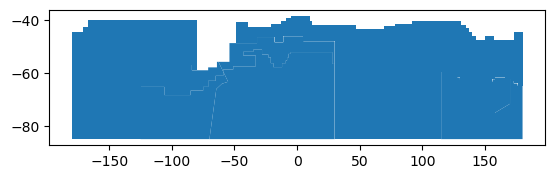

In [3]:
#Loading the MEASO shapefile
regions = geopandas.read_file(r'../SupportingData/MEASO/measo_wgs84.shp')
#Removing the temperate zone
regions = regions.query('zone != "Temperate"')
#Removing duplicated areas - based on geometry column, which contains the sector boundaries
regions = regions[-regions.duplicated('geometry')]
#Resetting indices
regions = regions.reset_index(drop = True)
       
#Plotting shapefile
regions.plot()

# Loading ACCESS-OM2 data sample for the Southern Ocean 
To create the MEASO mask that can be used with ACCESS-OM2-01 outputs, we need a sample of the grid used by the model. We can access this through the COSIMA cookbook. We need a single time step for any variable. In this case, we chose to use the `area_t` variable which gives us the area of each pixel. Finally, we corrected the longitude in the ACCESS-OM2-01 grid so it goes from -180 to +180, instead of 0-360.  
  
**Note:** As explained above, masks are unique to a specific grid. Therefore, if multiple grids are used in the analysis, a mask should be created for each grid used. In this repository we used three different masks: one that matches ACCESS-OM2-01 outputs, one that matches sea ice concentration data, and another one that matches the mixed layer depth observations. These masks have been included in this repository, but this notebook shows how they were created.

In [4]:
#Accessing COSIMA cookbook
import cosima_cookbook as cc
session = cc.database.create_session()

#Loading data for area per pixel
data =  cc.querying.getvar('01deg_jra55v140_iaf_cycle2', 'area_t', session, frequency = 'static', n = -1)
#Subset data for the Southern Ocean only
data = data.sel(yt_ocean = slice(-80, -35))

#Correcting longitude values
data = zsf.corrlong(data)

#Checking results
data

<xarray.DataArray 'area_t' (yt_ocean: 844, xt_ocean: 3600)>
dask.array<getitem, shape=(844, 3600), dtype=float32, chunksize=(513, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 ... -35.2 -35.12 -35.04
Attributes:
    long_name:     tracer cell area
    units:         m^2
    valid_range:   [0.e+00 1.e+15]
    cell_methods:  time: point
    coordinates:   geolon_t geolat_t
    ncfiles:       ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_j...
    contact:       Andrew Kiss
    email:         andrew.kiss@anu.edu.au
    created:       2020-08-20
    description:   0.1 degree ACCESS-OM2 global model configuration under int...
    notes:         Run configuration and history: https://github.com/COSIMA/0...

# Checking MEASO regions and ACCESS-OM2 data are correctly aligned
Before creating the masks, we must ensure that the MEASO shapefile and the raster data (whether it comes from ACCESS-OM2-01 or observations) aligned correctly. If they do not align well, then the mask produced here will be erroneous and will result in incorrect results for analysis at a sector level.

<AxesSubplot:xlabel='xt_ocean', ylabel='tcell latitude [degrees_N]'>

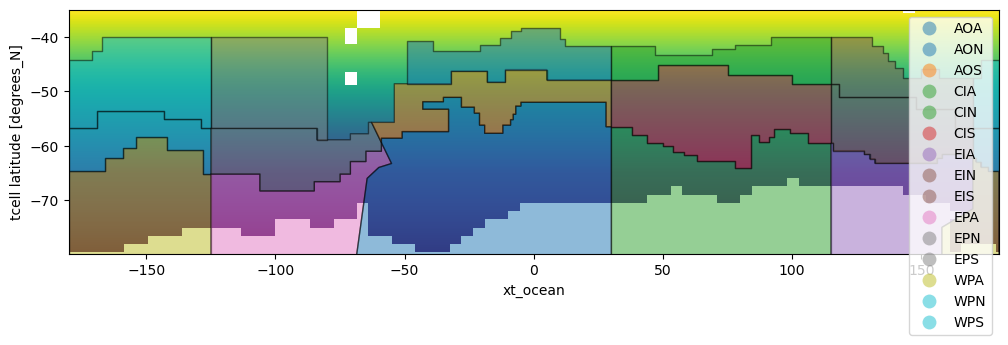

In [7]:
#Initialising figure
fig, ax = plt.subplots(figsize = (12, 15))

#Plot sample raster data
data.plot(ax = ax, add_colorbar = False)

#Plot shapefile over the top and show each sector in different colour
regions.plot(ax = ax, column = 'name', legend = True, alpha = 0.5, edgecolor = 'black')

# Creating a raster mask from MEASO regions
We will create a three dimensional mask with the MEASO regions. We will save the result as a `netcdf` file.

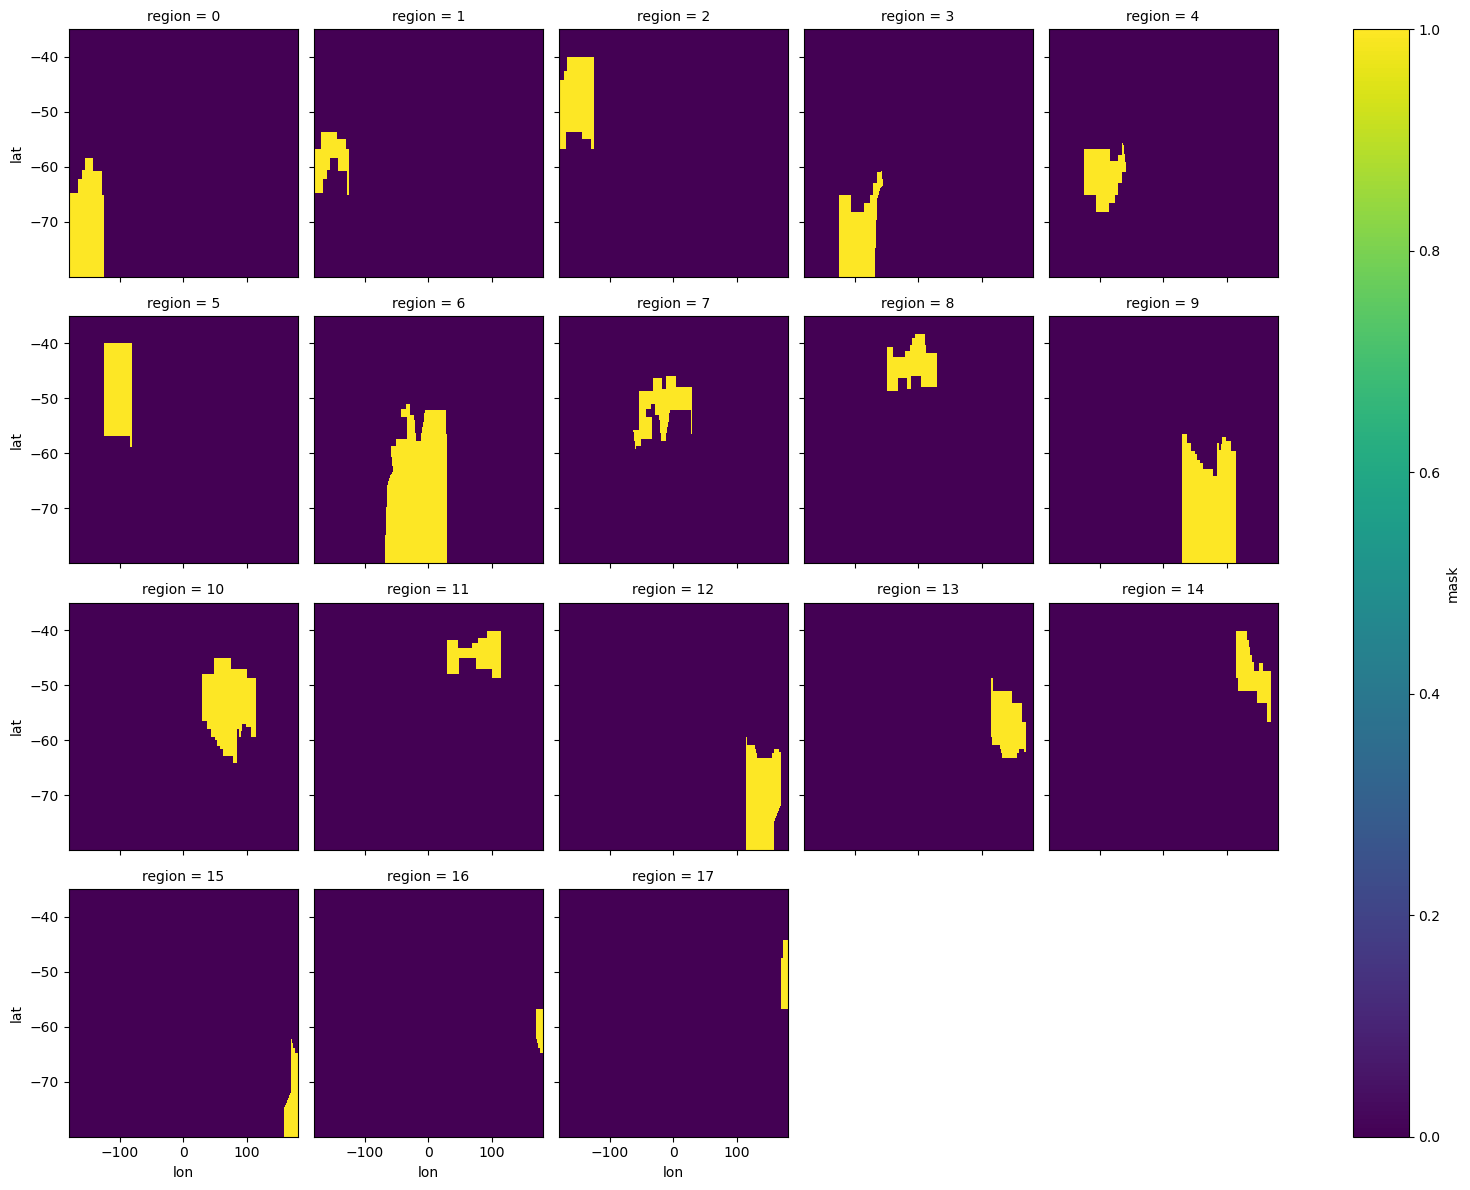

In [5]:
# Extracting latitude and longitude values from sample raster
xt_ocean = data['xt_ocean'].values
yt_ocean = data['yt_ocean'].values

#Creating a 3D mask, which includes regions as a dimension
mask3D = regionmask.mask_3D_geopandas(regions, xt_ocean, yt_ocean)
#Plotting all regions within mask to check they are correct
mask3D.plot(col = 'region', col_wrap = 5)

## Renaming regions
When the mask was created, numeric values were assigned to the `region` dimension which correspond to their index in the shapefile used to create the mask. In this step, regions will be renamed so the long version of its name (column `LongName` in the shapefile) will appear as the value in the `region` dimension of the mask. 

In [6]:
#Replacing numbered regions for names in the mask
mask3D['region'] = regions.LongName.values.tolist()

#Checking results
mask3D.region

<xarray.DataArray 'region' (region: 18)>
array(['West Pacific Antarctic', 'West Pacific Subantarctic',
       'West Pacific Northern', 'East Pacific Antarctic',
       'East Pacific Subantarctic', 'East Pacific Northern',
       'Atlantic Antarctic', 'Atlantic Subantarctic', 'Atlantic Northern',
       'Central Indian Antarctic', 'Central Indian Subantarctic',
       'Central Indian Northern', 'East Indian Antarctic',
       'East Indian Subantarctic', 'East Indian Northern',
       'West Pacific Antarctic', 'West Pacific Subantarctic',
       'West Pacific Northern'], dtype='<U27')
Coordinates:
  * region   (region) <U27 'West Pacific Antarctic' ... 'West Pacific Northern'

## Merging duplicate West Pacific areas
Areas within the West Pacific sector appear twice in the mask. This is because these areas are split in two along the -180/+180 longitude boundary. We need to merge these two areas together so any analysis at a sector level takes into account the entire area and does not incorrectly split the data.  
  
First, we will create a list of sectors that are repeated more than once in our recently created mask.

In [7]:
#Creating a list of repeated sectors
repeated = [i for i, count in collections.Counter(mask3D.region.values).items() if count > 1]
#See results
repeated

['West Pacific Antarctic',
 'West Pacific Subantarctic',
 'West Pacific Northern']

We can see that the West Pacific sectors are the ones that appear more than once in the mask. This makes sense since the West Pacific straddles the international dateline. We will now merge these areas so they only appear once.

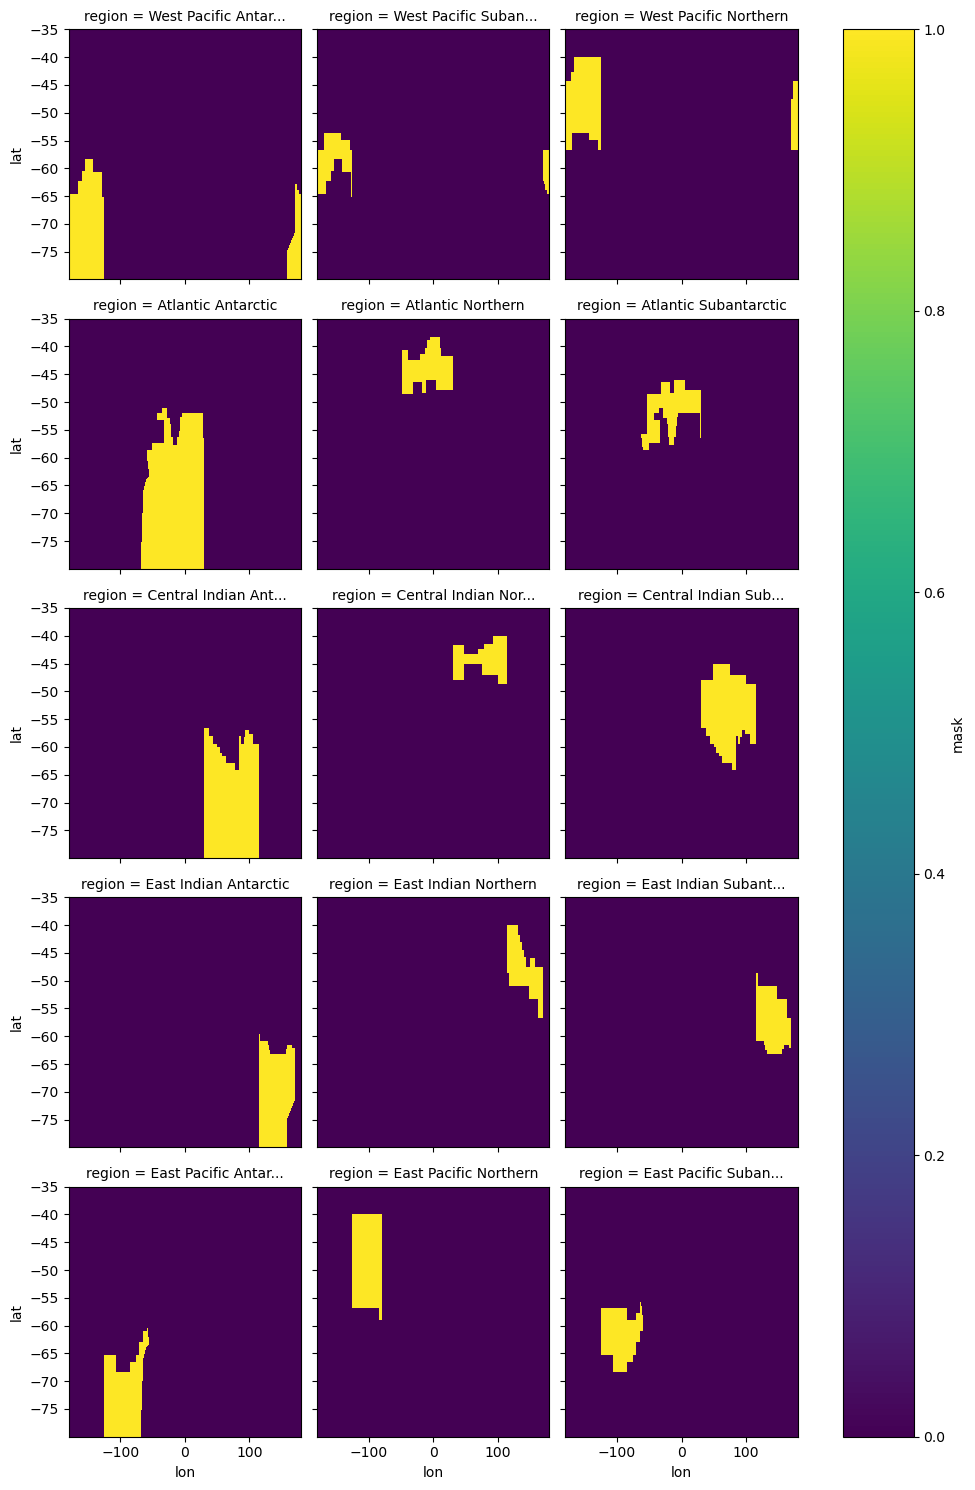

In [8]:
#Creating an empty variable to store the corrected areas
corr_reg = []

#We will loop through each repeated area
for i in repeated:
    reg = [i]
    #Sum together areas with the same value under region
    x = mask3D.sel(region = i).sum('region')
    #Include the region dimension again as this will be automatically dropped after summing
    x = x.expand_dims({'region': reg})
    #Include resulting data arrays in the empty variable created at the beginning of this section
    corr_reg.append(x)

#Appending all other regions
non_rep = sorted([sec for sec in set(mask3D.region.values) if sec not in repeated])
for i in non_rep:
    reg = [i]
    #Sum together areas with the same value under region
    x = mask3D.sel(region = i)
    #Include the region dimension again as this will be automatically dropped after summing
    x = x.expand_dims({'region': reg})
    #Include resulting data arrays in the empty variable created at the beginning of this section
    corr_reg.append(x)
        
#Concatenate all information into one new data array
corrected_mask = xr.concat(corr_reg, 'region')

#Checking the final result, which should include 15 areas in total
corrected_mask.plot(col = 'region', col_wrap = 3)

We now have the 15 MEASO sectors we need for our analyses.

## Final touches to complete our mask
There are a couple of steps we need to complete before finalising the mask:
- Replace zero values with `NA` in our mask
- Ensure our mask longitude and latitude dimensions match those in the sample raster
  
In this example, the dimension names used are those used in ACCESS-OM2-01. However, you must ensure the dimension names match those of the original sample raster used to create the mask.

In [12]:
#Replacing zeroes with NAs
corrected_mask = corrected_mask.where(corrected_mask != 0)

#Renaming dimensions
corrected_mask = corrected_mask.rename({'lon': 'xt_ocean','lat': 'yt_ocean'})

## Plotting final mask
We will plot just the first region to check that our final changes have been applied correctly.

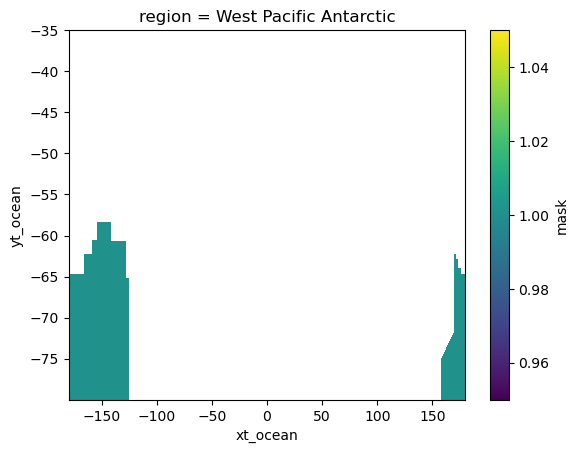

In [18]:
corrected_mask[0].plot()

## Saving final mask
Once we are happy with our mask, we can save the results as a `netcdf` file for use in our analyses.

In [107]:
corrected_mask.to_netcdf(r'../SupportingData/Masks/MEASO_ACCESS_3Dmask.nc')